# Mash based clustering of the dataset

In [42]:
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

#import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import yaml
import matplotlib.patches as mpatches

sns.set_context("paper")

In [43]:
with open("config.yaml", "r") as f:
    notebook_configuration = yaml.safe_load(f)
notebook_configuration

{'bgcflow_dir': '/datadrive/bgcflow'}

In [44]:
# Write samples.csv table to config directory of qc_strepto_ncbi project
bgcflow_dir = Path(notebook_configuration["bgcflow_dir"])
project_name_1 = "mq_strepto"
processed_dir_1 = bgcflow_dir / "data" / "processed" / project_name_1

# Read output tables from the processed directory
ncbi_meta_table = processed_dir_1 / "tables"/ "df_ncbi_meta.csv"
df_ncbi_meta = pd.read_csv(ncbi_meta_table, index_col= 0)

gtdb_meta_table = processed_dir_1 / "tables"/ "df_gtdb_meta_curated.csv"
df_gtdb_meta = pd.read_csv(gtdb_meta_table, index_col= 0)

seqfu_meta_table = processed_dir_1 / "tables"/ "df_seqfu_stats.csv"
df_seqfu_meta = pd.read_csv(seqfu_meta_table, index_col= 0)

mash_table = processed_dir_1 / "mash"/ "df_mash.csv"
df_mash = pd.read_csv(mash_table, index_col= 0)

filters_table = processed_dir_1 / "tables" / "df_filters.csv"
df_filter_quality = pd.read_csv(filters_table, index_col=0)

# 1. Clustering of MASH using a threshold of 50 on the distance dendrogram

In [4]:
cutoff = 50

# Subtracting Mash distances from 1 to convert to similarity
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')
clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')

# # Plotting the dendrogram
# plt.figure(figsize=(8, 6))
# dendrogram(linkage_matrix, color_threshold=0)  # Adjust the threshold as needed
# plt.axhline(y=cutoff, color='black', linestyle='--')  # Add a horizontal line at threshold
# plt.xticks([])  # Remove x-axis tick labels
# plt.title('Dendrogram based on MASH')
# plt.savefig("assets/figures/Figure_2/dendrogram.png")
# plt.savefig("assets/figures/Figure_2/dendrogram.svg")
# plt.show()

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

# Create dataframe assigning genomes to clusters
df_mash_clusters = pd.DataFrame({'Cluster': clusters}, index=df_similarity.index)

# Define the colors for 15 detected clusters
color_set_15 = ["#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6", "#d2f53c", "#fabebe", "#008080", "#e6beff", "#aa6e28", "#fffac8", "#800000"]
cluster_list = df_mash_clusters.Cluster.value_counts().index.tolist()
cluster_color_dict = dict(zip(cluster_list, color_set_15))

# Update df_mash_clusters
df_mash_clusters["Color"] = [cluster_color_dict[df_mash_clusters.loc[genome_id, "Cluster"]] for genome_id in df_mash_clusters.index]
df_mash_clusters["Species"] = df_gtdb_meta.loc[df_mash_clusters.index,"Species"]
df_mash_clusters = df_mash_clusters.loc[df_reordered.index, :]

In [5]:
df_mash_clusters.to_csv("assets/tables/df_mash_clusters_50_threshold.csv")

## Silhouette coefficient assessment

Assess the above clustering using the silhouette coefficient for each of the detected clusters

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score

df_clusters = df_mash_clusters.loc[df_similarity.index,:]
# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(df_similarity, clusters)

# Calculate average silhouette coefficient for each cluster
cluster_silhouette_scores = []
for cluster in sorted(df_clusters['Cluster'].unique()):
    cluster_samples = df_clusters['Cluster'] == cluster
    average_silhouette_score = silhouette_values[cluster_samples].sum() / len(silhouette_values[cluster_samples])
    cluster_silhouette_scores.append((cluster, average_silhouette_score))

# Print the average silhouette coefficient for each cluster
for cluster, score in cluster_silhouette_scores:
    print(f"Cluster {cluster}: {score}")

Cluster 1: 0.08797221573544257
Cluster 2: 0.4862582721703919
Cluster 3: 0.1658254149247081
Cluster 4: 0.1960594178851024
Cluster 5: 0.17904694911705502
Cluster 6: 0.5873838249993998
Cluster 7: 0.3254679956325633
Cluster 8: 0.337078929541414
Cluster 9: 0.8682892462707277
Cluster 10: 0.4609603976977143
Cluster 11: 0.18189367952061666
Cluster 12: 0.5829117688829909
Cluster 13: 0.26501793120660155
Cluster 14: 0.5704998483851392
Cluster 15: 0.23322471200305486


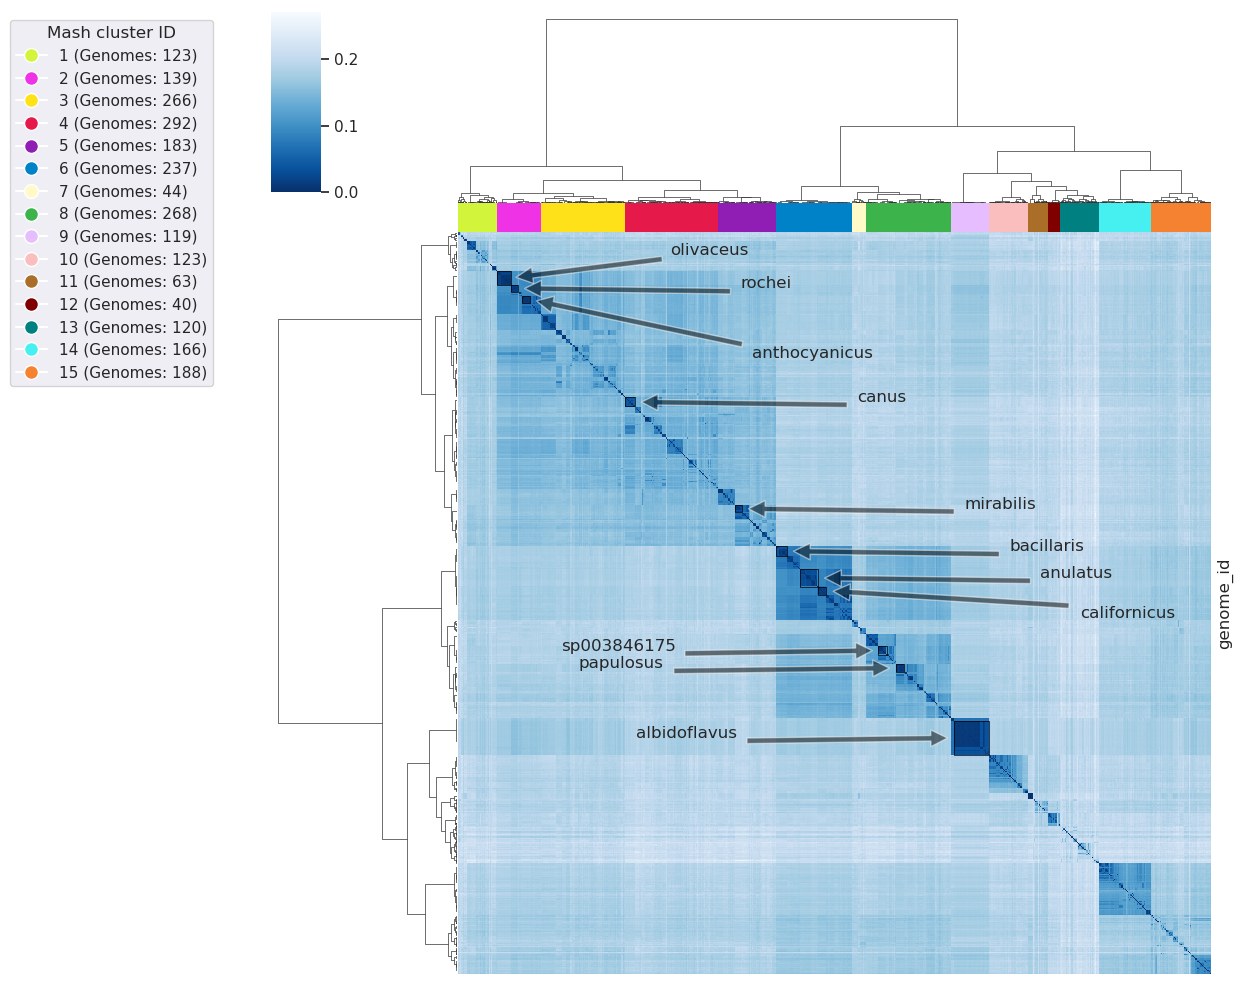

In [46]:
# Plotting the clustermap below the dendrogram
col_colors = [cluster_color_dict[df_mash_clusters.loc[genome_id, "Cluster"]] for genome_id in df_mash.index]
sns.set(font_scale=1.0)  # Adjust font size for row labels
g = sns.clustermap(df_mash, cmap='Blues_r', 
                   row_linkage=linkage_matrix, col_linkage=linkage_matrix, 
                   # vmax=0.25, 
                   col_colors= col_colors,
                   xticklabels=False, yticklabels=False)

# Create a color legend with unique cluster colors
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[cluster],
                           markersize=10) for cluster in sorted(cluster_list)]

cluster_sizes = df_mash_clusters.Cluster.value_counts()
labels = [f"{cluster} (Genomes: {cluster_sizes[cluster]})" for cluster in sorted(cluster_list)]

# Add color legend
plt.legend(color_legend, labels, title='Mash cluster ID', bbox_to_anchor=(-1, 1))

# Highlighting square
from matplotlib.patches import Rectangle

species_list = ["albidoflavus", "anulatus", "olivaceus", "bacillaris", "canus", "sp003846175", 
                "papulosus", "anthocyanicus", "californicus", "mirabilis", "rochei"]
for selected_species in species_list:
    x_min = 0 
    y_min = 0 
    xy_size = 0
    
    for idx in range(df_mash_clusters.shape[0]):
        if selected_species == df_mash_clusters.iloc[idx, 2]:
            xy_size = xy_size + 1
            if x_min == 0:
                x_min = idx
                y_min = idx      
    
    highlight = Rectangle((x_min, y_min), xy_size, xy_size, fill=False, edgecolor='black', lw=0.5)  # square with lower-left corner at (0,0), width and height 2
    g.ax_heatmap.add_patch(highlight)
    g.ax_heatmap.plot()  # Refresh the plot
    
    # Adding text label
    if selected_species == "olivaceus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+500, y_min-50),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif selected_species == "anthocyanicus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+200),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif selected_species == "californicus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+800, y_min+100),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif selected_species == "parvus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+200),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif x_min > 1200:
        g.ax_heatmap.annotate(selected_species, xy=(x_min, y_min+xy_size/2), xytext=(x_min-1000, y_min+xy_size/2),
                     arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    else:
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+700, y_min+xy_size/2),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))

plt.savefig("assets/figures/Figure_2/mash_threshold_50.png")
# plt.savefig("assets/figures/Figure_2/mash.svg")
plt.show()

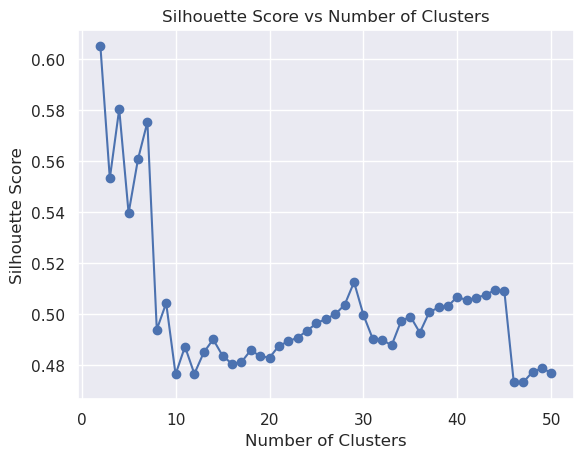

In [56]:
# Define a range of possible numbers of clusters
min_clusters = 2
max_clusters = 50

# Variables to store the silhouette scores
silhouette_scores = []

# Iterate over different numbers of clusters
for num_clusters in range(min_clusters, max_clusters+1):
    # Use fcluster to assign cluster labels
    clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

    # Calculate the silhouette score
    score = silhouette_score(distances, clusters)
    
    # Store the silhouette score
    silhouette_scores.append(score)

# Plot the silhouette scores against the number of clusters
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

In [58]:
# Define the desired number of clusters
num_clusters = 7

# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Create a new DataFrame with cluster column
df_clusters = pd.DataFrame({'Cluster': clusters}, index=df_similarity.index)

# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(distances, clusters)

# Calculate average silhouette coefficient for each cluster
cluster_silhouette_scores = []
for cluster in sorted(df_clusters['Cluster'].unique()):
    cluster_samples = df_clusters['Cluster'] == cluster
    average_silhouette_score = silhouette_values[cluster_samples].sum() / len(silhouette_values[cluster_samples])
    cluster_silhouette_scores.append((cluster, average_silhouette_score))

# Print the average silhouette coefficient for each cluster
for cluster, score in cluster_silhouette_scores:
    print(f"Cluster {cluster}: {score}")

Cluster 1: 0.40808821012939356
Cluster 2: 0.6270331360017528
Cluster 3: 0.6112720444105616
Cluster 4: 0.9617592553405367
Cluster 5: 0.23040939626083545
Cluster 6: 0.8493391177462573
Cluster 7: 0.48557947125820516


In [59]:
df_clusters["Silhouette"] = silhouette_values
df_silhouette = df_clusters.copy()

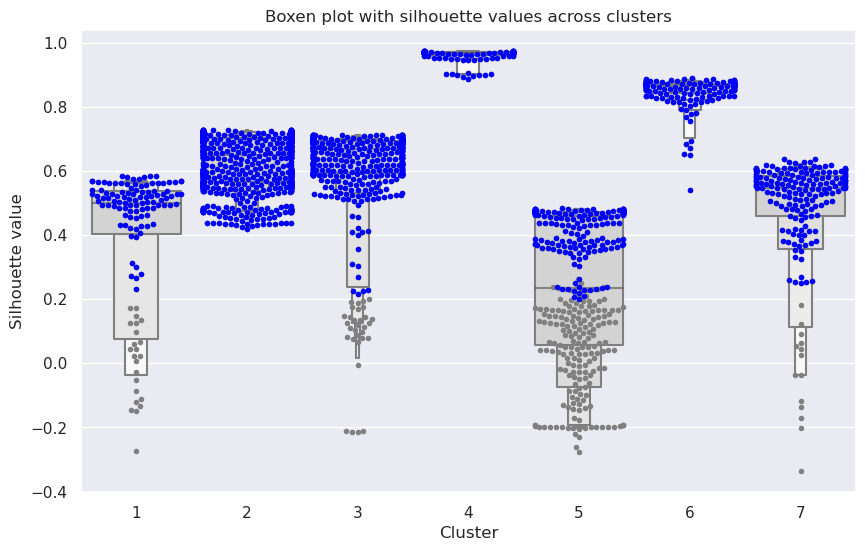

In [60]:
# Filter the DataFrame to keep only the samples with silhouette scores greater than the threshold
threshold = -1
df_silhouette_filtered = df_silhouette[df_silhouette['Silhouette'] > threshold]

data = df_silhouette_filtered.copy()
# Define the quantiles to restrict the plot for each category
# lower_cutoffs = {1:0.4, 2:0.4, 3:0.5, 4:0.25, 5:0.75, 6:0.4}

# Create an empty list to store the filtered data for each category
filtered_data_list = []

# color_map = {'1': '#e6194b',
#  '2': '#3cb44b',
#  '3': '#ffe119',
#  '4': '#0082c8',
#  '5': '#f58231',
#  '6': '#911eb4'}

# Iterate through each category and filter the data based on the quantiles
for category in sorted(data['Cluster'].unique()):
    category_data = data[data['Cluster'] == category]
    cutoff_value = 0.2 #lower_cutoffs[category]
    filtered_category_data = category_data[category_data['Silhouette'] >= cutoff_value]
    filtered_data_list.append(filtered_category_data)
    
# Concatenate the filtered data for all categories
filtered_data = pd.concat(filtered_data_list)

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, color="Blue")
# sns.pointplot(x='Cluster', y='Silhouette', data=data, color='black', markers='x', join=False, ci=None)
# sns.pointplot(x='Cluster', y='Silhouette', data=pd.DataFrame(list(lower_cutoffs.items()), columns=['Cluster', 'Silhouette']),
#               color='red', markers='s', join=False, ci=None)
plt.title('Boxen plot with silhouette values across clusters')
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# # Plot the chosen lower cutoff values
# for category, value in lower_cutoffs.items():
#     category_data = data[data['Cluster'] == category]
#     plt.text(category - 1.4, category_data.Silhouette.max() + 0.02, f'Cutoff: {value:.2f}', color='black')

# Show the plot
# plt.legend(['Data', 'Outliers', 'Cutoff Upper', 'Cutoff Lower'])
# plt.savefig("assets/figures/Figure_2/silhouette.png")
plt.show()